## Code Attribution

The code presented in this section, which generates dynamic spectra with varying pulse parameters, is the result of my work and has been adapted from Python notebooks authored by Joseph Kania. These notebooks utilized the WILL (Weighted Injector of Luminous Lighthouses) Python package.

### Code Author
- **Dirk Kuiper**

### Sources
The code has been adjusted and customized from the following sources:

- Joseph Kania's Python example notebooks, which provided the foundational code for generating dynamic spectra with pulses. These notebooks served as a valuable reference and inspiration for the implementation of the following code.

- The WILL (Weighted Injector of Luminous Lighthouses) Python package, which was used for several functions and utilities, enhancing the capabilities of the code.


## Show how we can inject a pulse into a GREENBURST filterbank.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion import dedisperse
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject, detect
from simulate_frbs import *
from plotting import *

## Creating a fresh filterbank file from scratch

Code adapted from: https://thepetabyteproject.github.io/your/0.6.6/ipynb/Writer/

I tried to make the header as consistent as possible with the Greenbank data from Zenodo, in case we will want to use it later to test with RFI etc.

In [2]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=512, num_time_samples=1024)

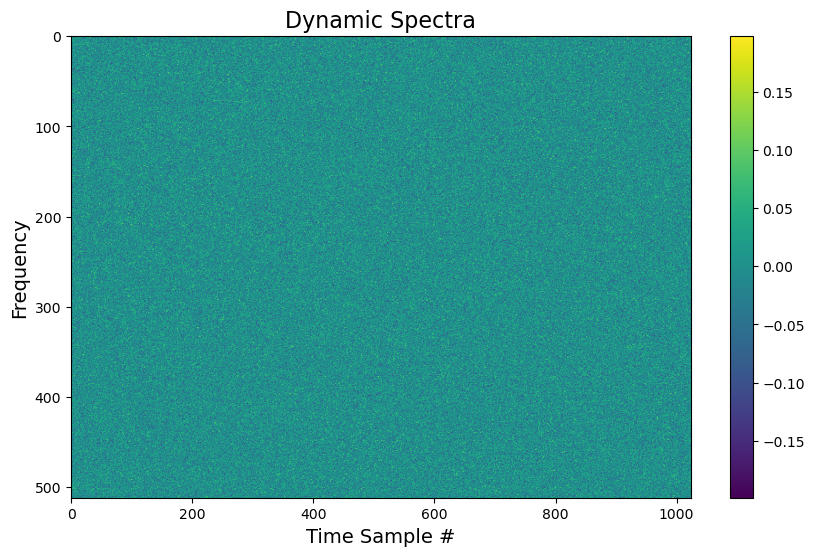

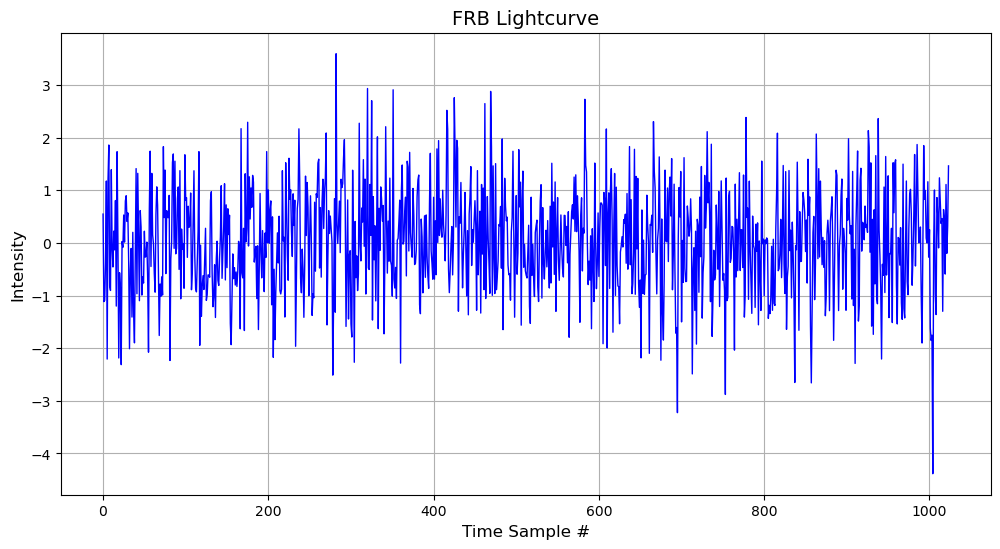

In [3]:
# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)

# Plot the dynamic spectra
plot_dynamic_spectra(dynamic_spectra)

# Sum the dynamic spectra along the frequency axis to create a lightcurve
lightcurve = np.sum(dynamic_spectra, axis=1)

# Plot the lightcurve using time sample numbers as the x-axis
plot_lightcurve(lightcurve=lightcurve, time_samples=np.arange(1024))


## Create a simple Pulse

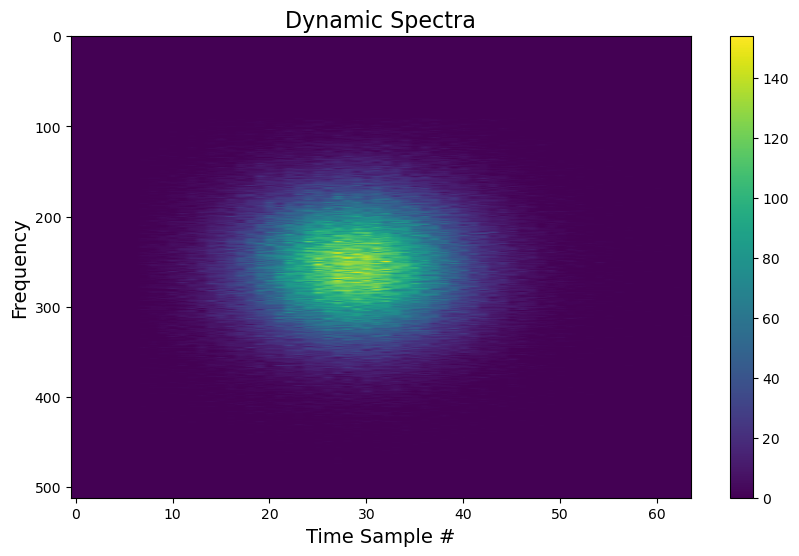

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Maximum value in the pulse: 154.0


In [19]:
dm = 0
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=0.015/8,
    sigma_freq=100/8,
    center_freq=yr_obj.your_header.center_freq,
    dm=dm,
    tau=0,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=None,
)


# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5), dtype=np.float32)

plot_dynamic_spectra(pulse)

print(pulse)
max_value = np.max(pulse)

print(f"Maximum value in the pulse: {max_value}")


## Scale the pulse for SNR

In [20]:
scaling_factor = get_scaling_factor(min_value=0.0002, max_value=0.003, exponent = -1.5)

pulse = (pulse * scaling_factor).astype(np.float32)

## Inject the Pulse

In [21]:
# Inject the pulse into the dynamic spectrum
dynamic_spectra_with_pulse = inject_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

## Show injected Pulse

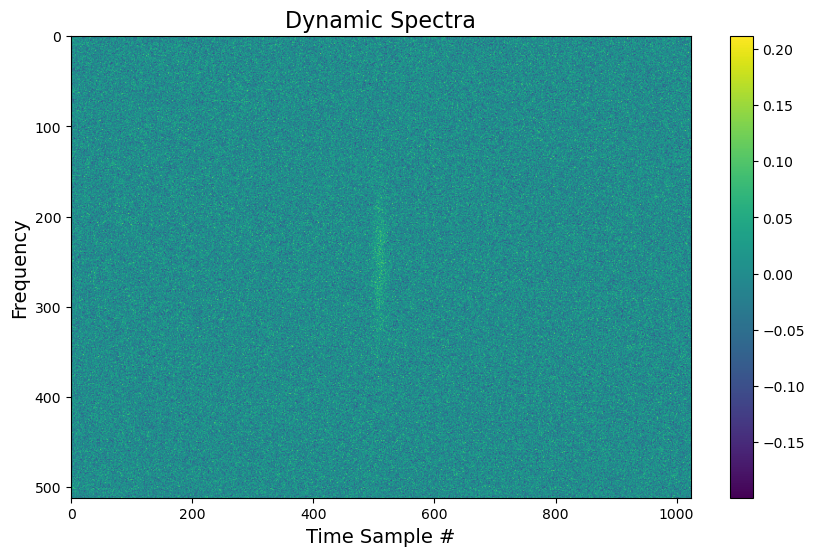

In [22]:
plot_dynamic_spectra(dynamic_spectra_with_pulse)

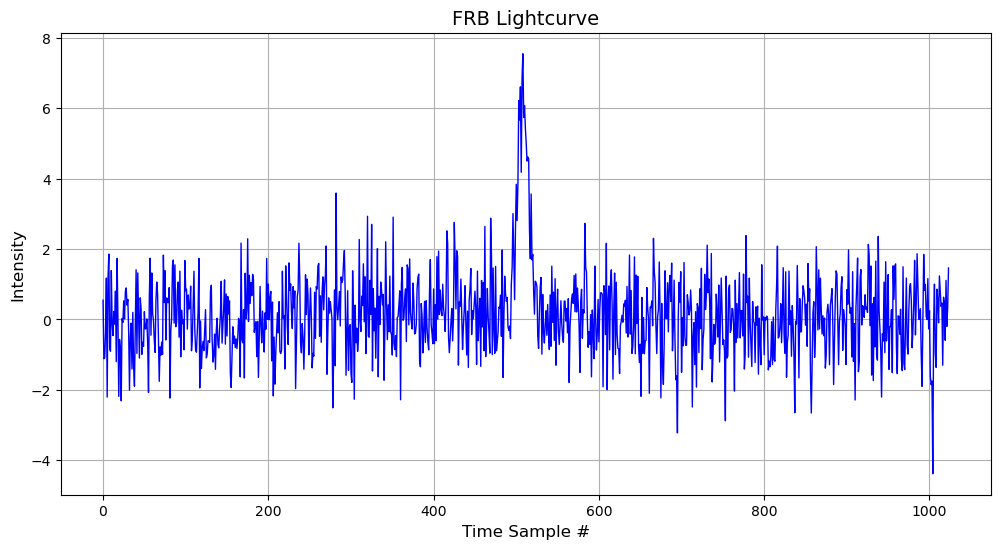

RMS of the noise: 1.0262606143951416
7.5520716
1.0250125
7.367785
7.3588243


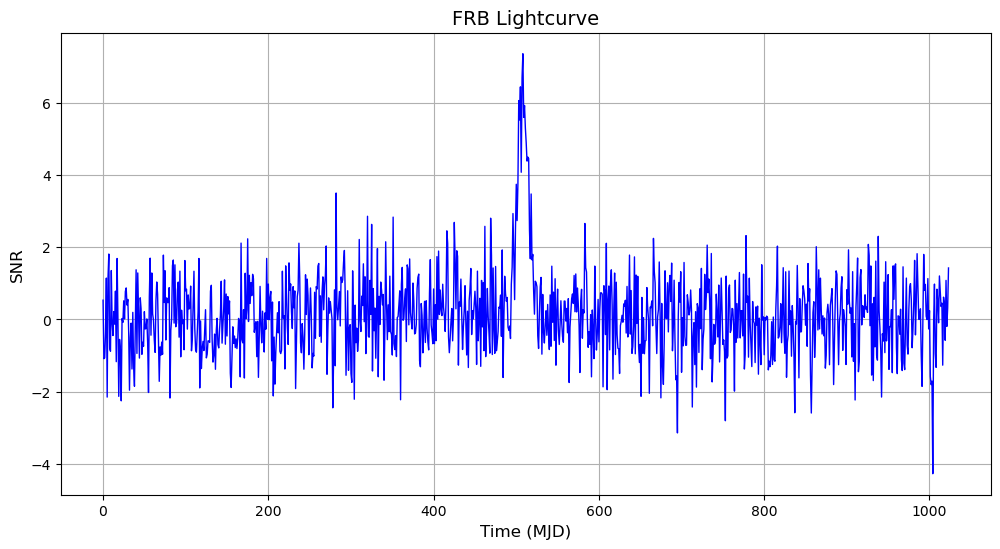

In [23]:
# Sum the frequencies along the frequency axis to get a 1D time series (lightcurve)
lightcurve = np.sum(dynamic_spectra_with_pulse,axis=1)

plot_lightcurve(time_samples=np.arange(1024), lightcurve=lightcurve)

squared_values = lightcurve[0:100] ** 2

# Calculate the mean of the squared values
mean_squared = np.mean(squared_values)

# Take the square root to get the RMS
rms = np.sqrt(mean_squared)

print(f"RMS of the noise: {rms}")

print(np.max(lightcurve))
print(np.std(lightcurve[0:100]))

print(np.max(lightcurve) / np.std(lightcurve[0:100]))

print(np.max(lightcurve)/rms)

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1024), lightcurve/np.std(lightcurve[0:100]), color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("SNR", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()


## Now for a pulse with a scattering tail

In [12]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=512, num_time_samples=1024)

# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)

(576, 512)


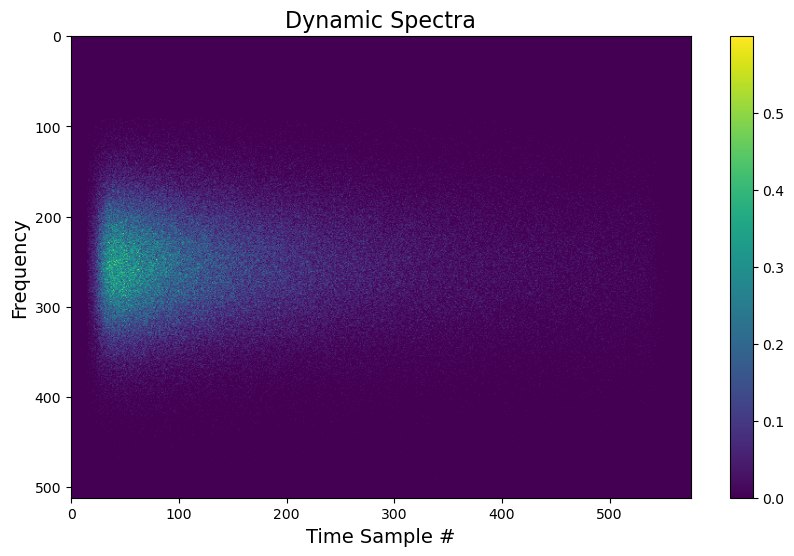

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Maximum value in the pulse: 0.5999999642372131


In [13]:
dm = 0
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=0.015/8,
    sigma_freq=100/8,
    center_freq=yr_obj.your_header.center_freq,
    dm=dm,
    tau=65,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=None,
)


# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5), dtype=np.float32)

print(np.shape(pulse))

pulse = (pulse * 0.02).astype(np.float32)

plot_dynamic_spectra(pulse)

print(pulse)
max_value = np.max(pulse)

print(f"Maximum value in the pulse: {max_value}")

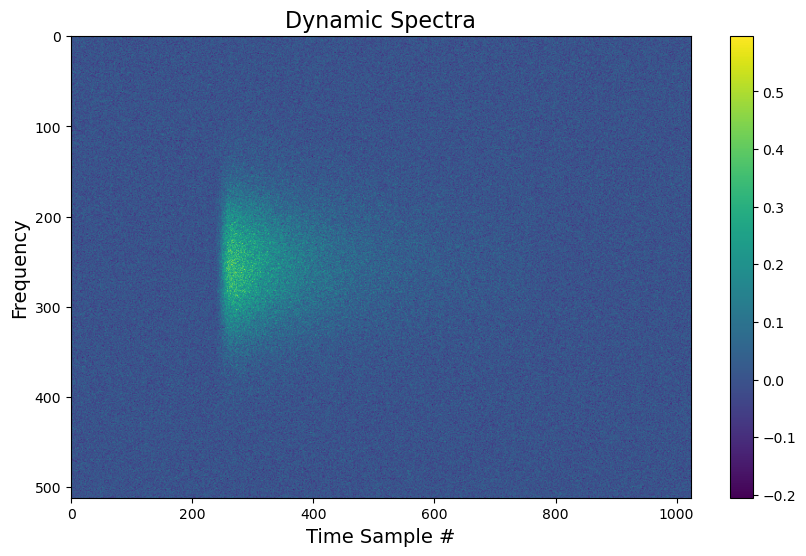

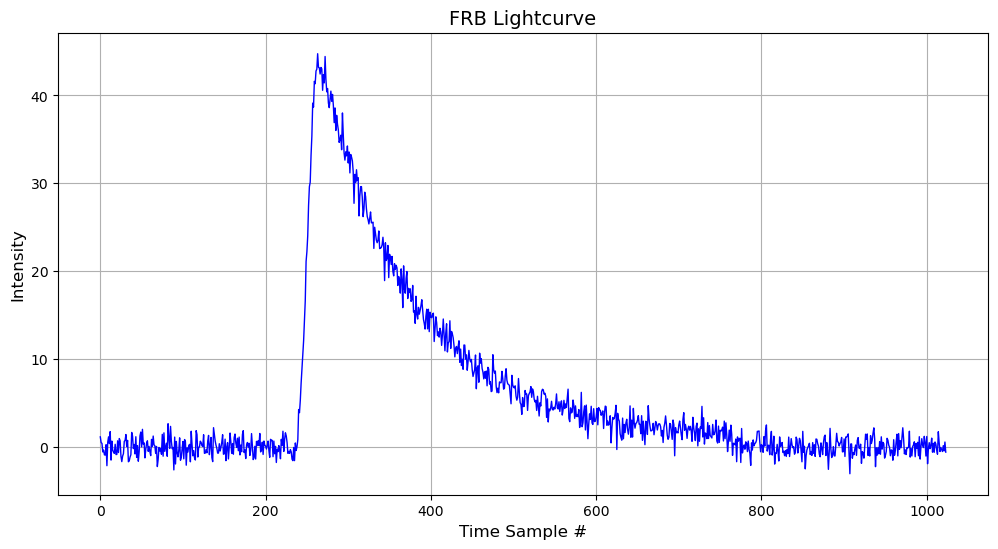

In [14]:
# Inject the pulse into the dynamic spectrum
dynamic_spectra_with_scattered_pulse = inject_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

plot_dynamic_spectra(dynamic_spectra_with_scattered_pulse)

lightcurve = np.sum(dynamic_spectra_with_scattered_pulse, axis=1)

plot_lightcurve(time_samples=np.arange(1024), lightcurve=lightcurve)

## Now for a pulse with complex time-frequency structure

In [15]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=512, num_time_samples=1024)

# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)

In [16]:
dm_1 = 0
pulse_obj_complex = create.GaussPulse(
    relative_intensities=(1, 1, 1),
    sigma_times=(0.01, 0.01, 0.01),
    sigma_freqs=(100, 100, 20),
    pulse_thetas=(0, 0, -180/np.pi),
    center_freqs=(yr_obj.your_header.center_freq, yr_obj.your_header.center_freq, yr_obj.your_header.center_freq -30),
    dm=dm_1,
    tau=0,
    offsets=(0, 0.05, 0.1),  # all from start of window
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    spectral_index_alpha=0,
    nscint=0,
    phi=np.pi / 3,
    bandpass=None,
)
# pulse with 3e5 samples
pulse_complex = pulse_obj_complex.sample_pulse(nsamp=int(3e5), dtype=np.float32)

max_value = np.max(pulse_complex)

print(f"Maximum value in the pulse: {max_value}")



Maximum value in the pulse: 12.0


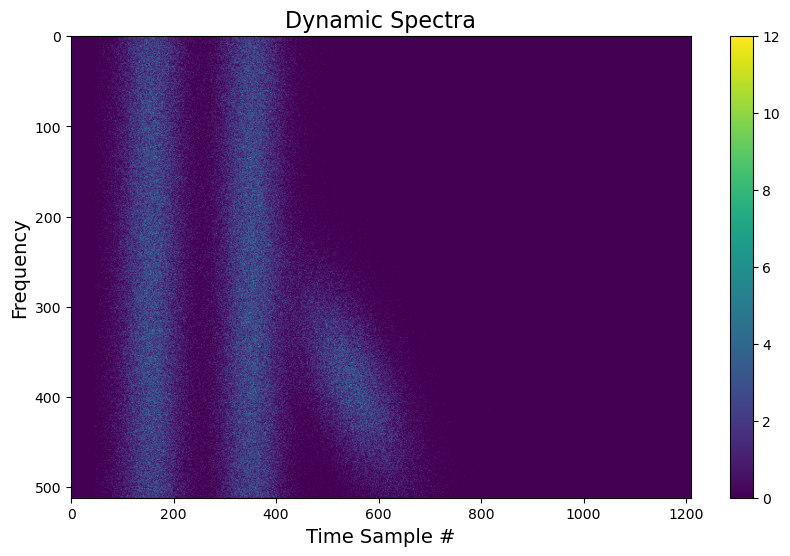

In [17]:
plot_dynamic_spectra(pulse_complex)

## Inject the pulse

Maximum value in the spectra: 11.989945411682129


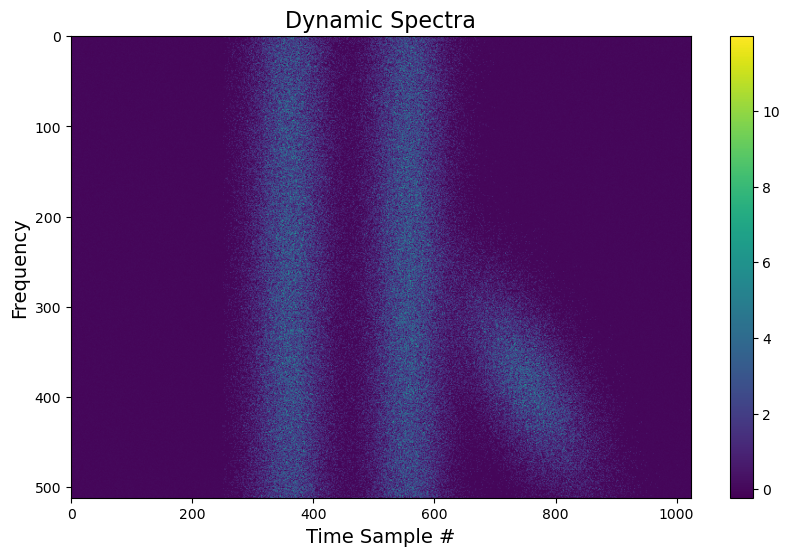

In [18]:
dynamic_spectra_with_complex_pulse = inject_pulse_into_dynamic_spectrum(dynamic_spectra, pulse_complex, pulse_start_time = dynamic_spectra.shape[0] // 5)

max_value = np.max(dynamic_spectra_with_complex_pulse)

print(f"Maximum value in the spectra: {max_value}")

plot_dynamic_spectra(dynamic_spectra_with_complex_pulse)


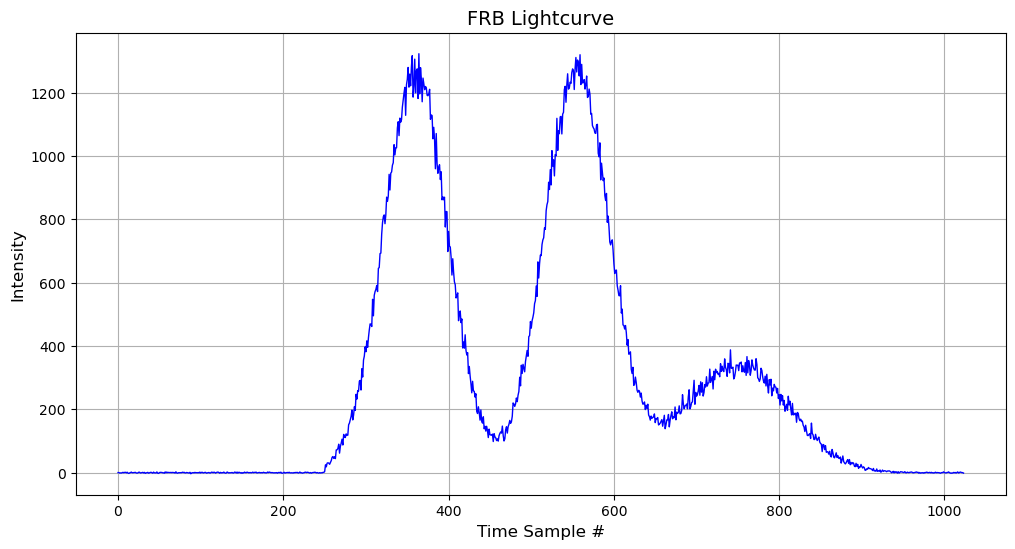

In [19]:
lightcurve_complex = np.sum(dynamic_spectra_with_complex_pulse, axis = 1)

plot_lightcurve(time_samples=(np.arange(1024)), lightcurve=lightcurve_complex)

## Generate complex frbs

In [ ]:
import os
import numpy as np

# Directory to save the numpy arrays for complex pulses
save_dir_complex = "simulated_complex_frbs"

# Create the directory if it doesn't exist
os.makedirs(save_dir_complex, exist_ok=True)

# Set the constant DM value
dm = 200

# Define the mean values for the Gaussian distributions
mean_value_for_sigma_time = 0.005  # Mean value for pulse width
mean_value_for_sigma_freq = 350    # Mean value for frequency width

# Standard deviations for the Gaussian distributions (adjust as needed)
std_deviation_for_sigma_time = 0.001
std_deviation_for_sigma_freq = 50

# Generate 10 different dynamic spectra with varying signal and temporal widths for complex pulses
num_pulses = 100

for i in range(num_pulses):
    # Draw random values for signal width and temporal width from Gaussian distributions
    sigma_time = np.random.normal(mean_value_for_sigma_time, std_deviation_for_sigma_time)
    sigma_freq = np.random.normal(mean_value_for_sigma_freq, std_deviation_for_sigma_freq)
    
    # Create the pulse object with the specified parameters for complex pulses
    pulse_obj_complex = create.GaussPulse(
        relative_intensities=(1, 0.8, 0.8, 0.8),
        sigma_times=(sigma_time, sigma_time * 0.2, sigma_time * 0.2, sigma_time * 1.2),
        sigma_freqs=(sigma_freq, sigma_freq * 0.8, sigma_freq * 0.8, sigma_freq * 0.6),
        pulse_thetas=(0, 0, 0, -np.pi / 60),
        center_freqs=(yr_obj.your_header.center_freq, yr_obj.your_header.center_freq - 100, yr_obj.your_header.center_freq - 200, yr_obj.your_header.center_freq - 400),
        dm=dm,
        tau=25,
        offsets=(0, 0.01536, 0.02304, 0.03968),  # all from start of window
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
        spectral_index_alpha=0,
        nscint=2,
        phi=0,
        bandpass=None,
    )

    # Scale the SNR of the pulse according to powerlaw with slope -1.5 so more weak pulses
    min_value = .75
    max_value = 5

    # Define the exponent for the power law distribution
    exponent = -1.5  # Use a negative exponent

    # Generate a random number from a power law-like distribution
    scaling_factor = ((max_value**(exponent+1) - min_value**(exponent+1)) * np.random.random(1) + min_value**(exponent+1))**(1/(exponent+1))

    # Generate the complex pulse signal with the specified parameters
    pulse_complex = pulse_obj_complex.sample_pulse(nsamp=int(3e5))

    pulse_complex = pulse_complex * int(scaling_factor)
    
    
    
    # Inject the complex pulse into the dynamic spectra
    dynamic_spectra_w_pulse_complex = inject.inject_constant_into_file(
        yr_input=yr_obj,
        pulse=pulse_complex,
        start=yr_obj.your_header.nspectra // 2,
        gulp=yr_obj.your_header.nspectra,
    )

    dynamic_spectra_w_pulse_complex_dedisp = dedisperse(
        dynamic_spectra_w_pulse_complex,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )
    
    # Define a filename for the numpy array for complex pulses
    filename_complex = os.path.join(save_dir_complex, f"complex_frb_{i}_{sigma_time}_{sigma_freq}.npy")
    
    # Save the dynamic spectra with complex pulses as a numpy array
    np.save(filename_complex, dynamic_spectra_w_pulse_complex_dedisp)


Injecting Pulses ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--